In [1]:
import os
import zipfile
from google.colab import drive

dataset_4 = True

if dataset_4:

  !rm /content/download
  !rm -r /content/imagedb/
  !rm -r /content/imagedb_test
  !wget https://vc.ee.duth.gr:6960/index.php/s/wlnkxtlGmqBeATC/download
  local_zip = '/content/download'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content')
  zip_ref.close()

  train_dir = '/content/imagedb'
  test_dir = '/content/imagedb_test'

else:
  drive.mount('/content/drive')
  local_zip = '/content/drive/MyDrive/caltech.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content')
  zip_ref.close()
  train_dir = '/content/caltech/imagedb'
  test_dir = '/content/caltech/imagedb_test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      6416      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      1

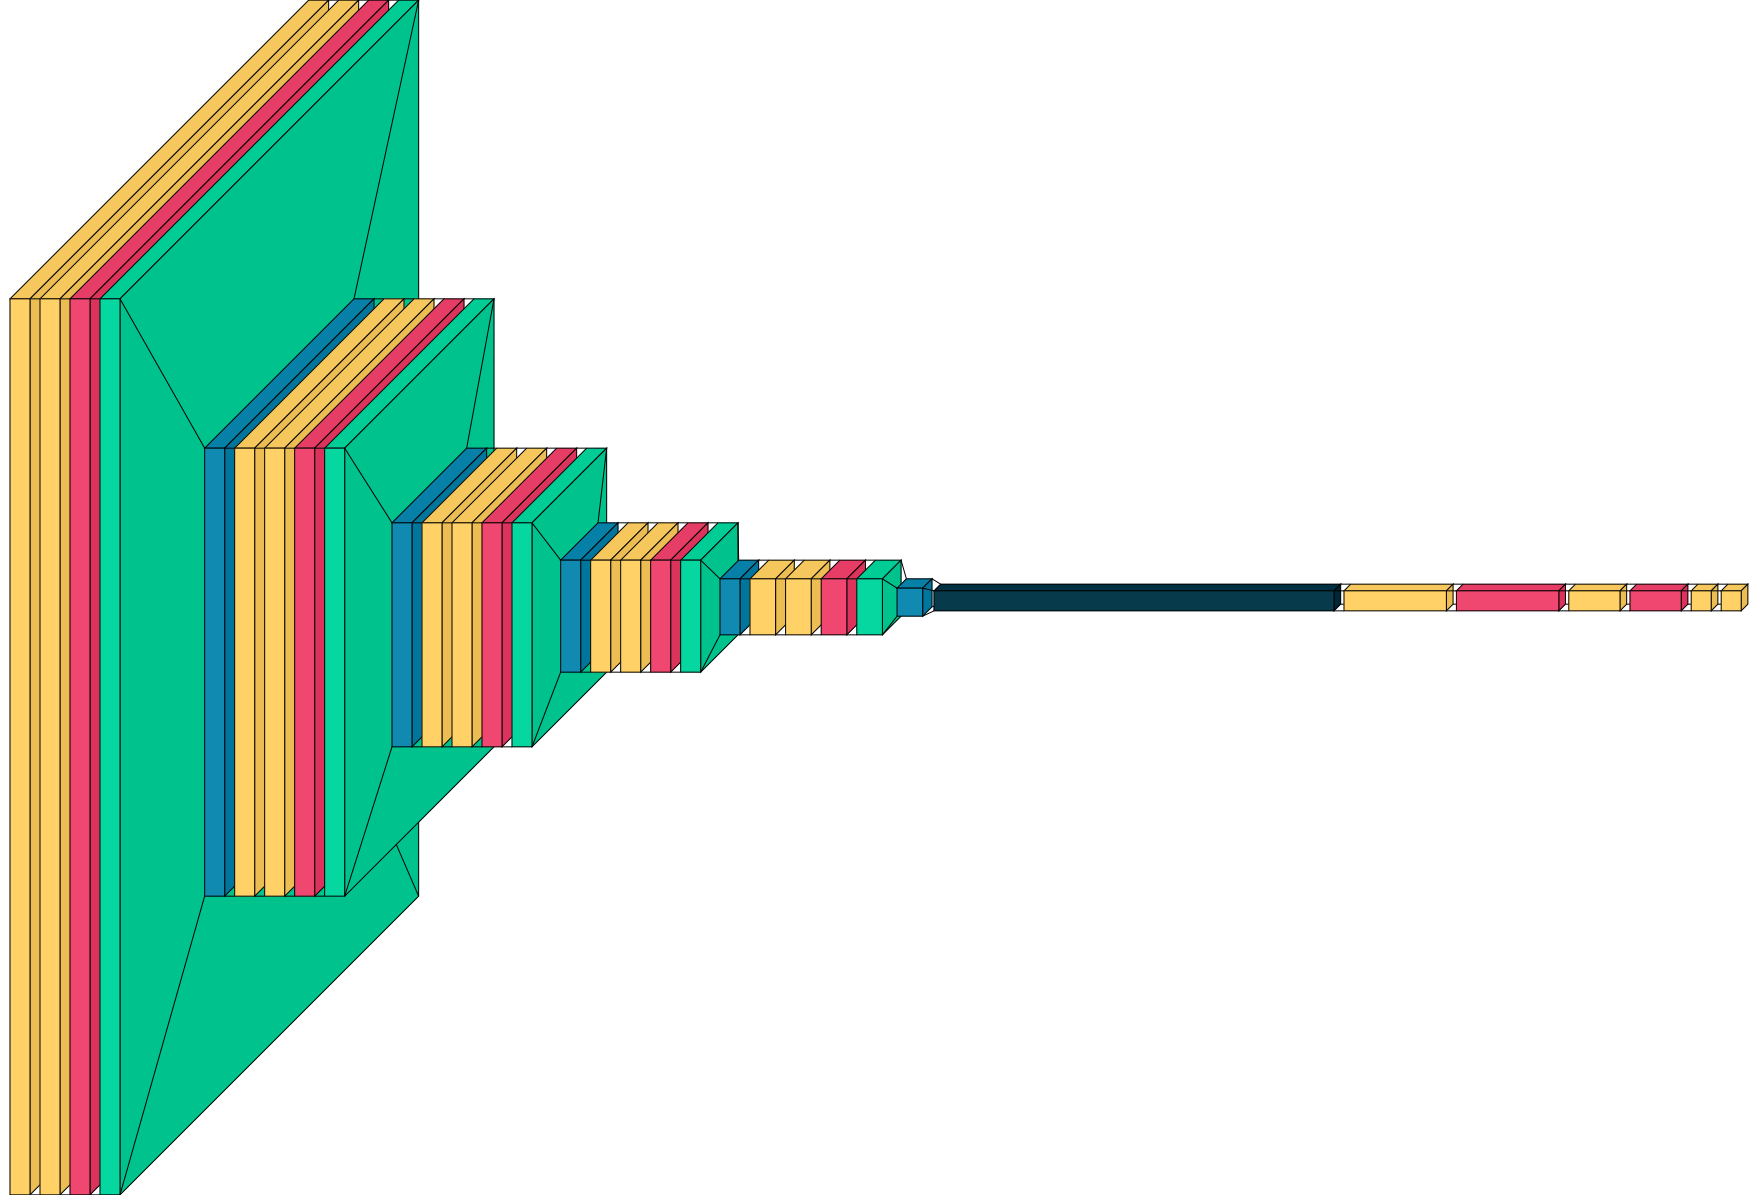

In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
import visualkeras

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, (5, 5), strides=(1, 1), input_shape=(224, 224, 3),padding='same'),
  tf.keras.layers.Conv2D(16, (5, 5), strides=(1, 1),padding='same'),
  tf.keras.layers.BatchNormalization(
    axis=-1,
    epsilon=0.001),
  tf.keras.layers.Activation(activations.relu),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'),
  tf.keras.layers.Conv2D(32, (5, 5), strides=(1, 1),padding='same'),
  tf.keras.layers.Conv2D(32, (5, 5), strides=(1, 1),padding='same'),
  tf.keras.layers.BatchNormalization(
    axis=-1,
    epsilon=0.001),
  tf.keras.layers.Activation(activations.relu),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'),
  tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1),padding='same'),
  tf.keras.layers.Conv2D(64, (5, 5), strides=(1, 1),padding='same'),
  tf.keras.layers.BatchNormalization(
    axis=-1,
    epsilon=0.001),
  tf.keras.layers.Activation(activations.relu),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'),
  tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1),padding='same'),
  tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1),padding='same'),
  tf.keras.layers.BatchNormalization(
    axis=-1,
    epsilon=0.001),
  tf.keras.layers.Activation(activations.relu),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1),padding='same'),
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1),padding='same'),
    tf.keras.layers.BatchNormalization(
    axis=-1,
    epsilon=0.001),
  tf.keras.layers.Activation(activations.relu),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding='same'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2,seed=1),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1,seed=1),
  tf.keras.layers.Dense(100,activation='relu'),
  if dataset_4:
    tf.keras.layers.Dense(34, activation='softmax')
  else:
    tf.keras.layers.Dense(5, activation='softmax')


])
# Show a summary of the model. Check the number of trainable parameters
model.summary()
visualkeras.layered_view(model)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from PIL import Image


train_datagen  = ImageDataGenerator(validation_split=0.2,horizontal_flip=True,rotation_range=15,zoom_range=(0.2))
#train_datagen  = ImageDataGenerator(validation_split=0.2)

# --------------------
# Flow training images in batches of 50 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=50,
                                                    class_mode='categorical',
                                                    # color_mode='grayscale',
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    subset='training', seed=1)     
# --------------------
# Flow validation images in batches of 50 using test_datagen generator
# --------------------
validation_generator =  train_datagen.flow_from_directory(train_dir,
                                                        batch_size=50,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(224,224),
                                                        subset='validation', seed=1) 

Found 388 images belonging to 5 classes.
Found 94 images belonging to 5 classes.


In [5]:
# Compile the model
from keras import models
from keras import layers
from keras import optimizers
import datetime

batch_size = 50
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.adam_v2.Adam(learning_rate=1e-4),
              metrics=['acc'])

callbacks = []
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=4,min_lr=1e-6)
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10, restore_best_weights=True, verbose=1,min_delta=0.003)

callbacks.append(early_stop_callback)
callbacks.append(reduce_lr)


# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples/validation_generator.batch_size,
      verbose=1,
     )
 
# Save the model
model.save('VaiaNet')

<ipython-input-5-87d4fef8f58b>:28: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
7/7 [==============================] - 21s 2s/step - loss: 1.4166 - acc: 0.4665 - val_loss: 4.2023 - val_acc: 0.2128
Epoch 2/100
7/7 [==============================] - 6s 758ms/step - loss: 0.6269 - acc: 0.7732 - val_loss: 3.3834 - val_acc: 0.2128
Epoch 3/100
7/7 [==============================] - 6s 753ms/step - loss: 0.4102 - acc: 0.8325 - val_loss: 3.3583 - val_acc: 0.2234
Epoch 4/100
7/7 [==============================] - 6s 766ms/step - loss: 0.3415 - acc: 0.8608 - val_loss: 2.1239 - val_acc: 0.2660
Epoch 5/100
7/7 [==============================] - 6s 735ms/step - loss: 0.2668 - acc: 0.9021 - val_loss: 1.4118 - val_acc: 0.4681
Epoch 6/100
7/7 [==============================] - 6s 727ms/step - loss: 0.2509 - acc: 0.9098 - val_loss: 1.9498 - val_acc: 0.4043
Epoch 7/100
7/7 [==============================] - 6s 736ms/step - loss: 0.1990 - acc: 0.9278 - val_loss: 1.6595 - val_acc: 0.4574
Epoch 8/100
7/7 [==============================] - 6s 745ms/step - loss: 0.1797 - acc

In [6]:
test_datagen  = ImageDataGenerator()
# --------------------
# Flow validation images in batches of 50 using test_datagen generator
# --------------------
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                        batch_size=50,
                                                        class_mode='categorical',
                                                        #  color_mode='grayscale',
                                                         target_size=(224,224)) 
loss, acc = model.evaluate(test_generator)

Found 52 images belonging to 5 classes.
2/2 [==============================] - 0s 290ms/step - loss: 0.3272 - acc: 0.9423


In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'],label='val_acc')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()

NameError: ignored

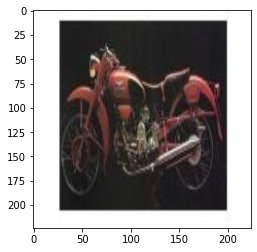

1/1 [==============================] - 0s 430ms/step



['145.motorbikes-101', '178.school-bus', '224.touring-bike', '251.airplanes-101', '252.car-side-101']



Softmax Output: [[9.9999607e-01 7.2230328e-09 2.1819087e-09 3.9572410e-06 1.5253546e-09]]



/content/caltech/imagedb_test/145.motorbikes-101/145_0090.jpg is a 145.motorbikes-101





In [8]:
from keras.utils import load_img, img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

if dataset_4:
  path = '/content/imagedb_test/00053/00001_00002.ppm'
else:
  path = '/content/caltech/imagedb_test/224.touring-bike/224_0061.jpg'

  
img = load_img(path, target_size=(224, 224), grayscale=False, interpolation='bilinear')
plt.imshow(img, cmap='gray')
plt.show()

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
model = tf.keras.models.load_model('VaiaNet')
classes_pred = model.predict(x)
if dataset_4:
  classes = ['00004','00005','00007','00008','00010','00012','00013','00017','00018','00019','00021','00027','00028','00029','00030','00031','00032',
             '00034','00035','00037','00038','00039','00041','00042','00043','00045','00047','00051','00053','00054','00056','00057','00058','00059']
else:
  classes = ['145.motorbikes-101','178.school-bus','224.touring-bike','251.airplanes-101','252.car-side-101']
print(f'\n\n\n{classes}')
print(f'\n\n\nSoftmax Output: {classes_pred}')
print(f'\n\n\n{path} is a {classes[classes_pred.argmax()]}\n\n\n')